# My EEG

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import mne
import microstates

matplotlib.use('Qt5Agg')
%matplotlib qt
#%matplotlib inline

size=16

In [144]:
folder = '/Users/giacomobarzon/Desktop/EEG-microstates/EEGsample/'
fname = folder + 'D008_location.set'

raw = mne.io.read_raw_eeglab(fname, preload=True)

Reading /Users/giacomobarzon/Desktop/EEG-microstates/EEGsample/D008_location.fdt
Reading 0 ... 666472  =      0.000 ...  1332.944 secs...


<ipython-input-144-81927e43ab3a>:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(fname, preload=True)
<ipython-input-144-81927e43ab3a>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


In [145]:
# rename bad annotations
raw.annotations.rename({'boundary': 'bad frames', 'Impedance':'bad frames'})

# rename eog and ecg channels
mne.rename_channels(raw.info, mapping={'BIP1':'EOG1', 'BIP2':'EOG2', 'BIP4':'ECG'})

# fix channel type of eog and ecg
raw.set_channel_types(mapping={'EOG1':'eog', 'EOG2':'eog', 'ECG':'ecg'})

<RawEEGLAB | D008_location.fdt, 33 x 666473 (1332.9 s), ~167.8 MB, data loaded>

In [ ]:
raw.describe()

In [ ]:
raw.plot_sensors(show_names=True)

In [146]:
# get events list
events, events_id = mne.events_from_annotations(raw)

print('total number of events:', len(events))
print('events id:', events_id)

Used Annotations descriptions: ['s1', 's11', 's2', 's21', 's31']
total number of events: 73
events id: {'s1': 1, 's11': 2, 's2': 3, 's21': 4, 's31': 5}


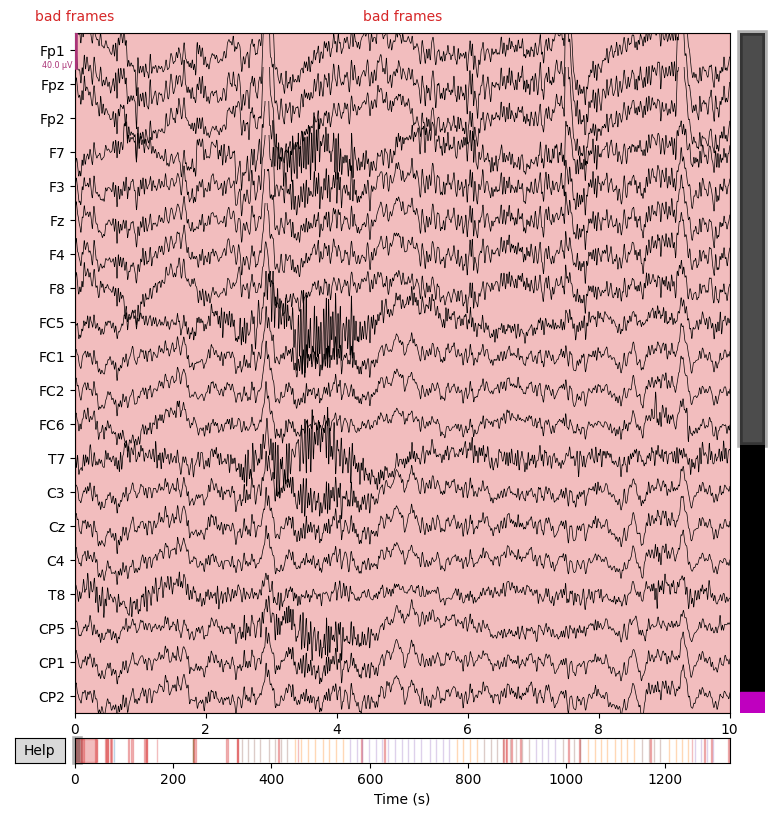

Channels marked as bad: ['O2']


In [128]:
raw.plot()

Setting 51327 of 666473 (7.70%) samples to NaN, retaining 615146 (92.30%) samples.
Effective window size : 4.096 (s)


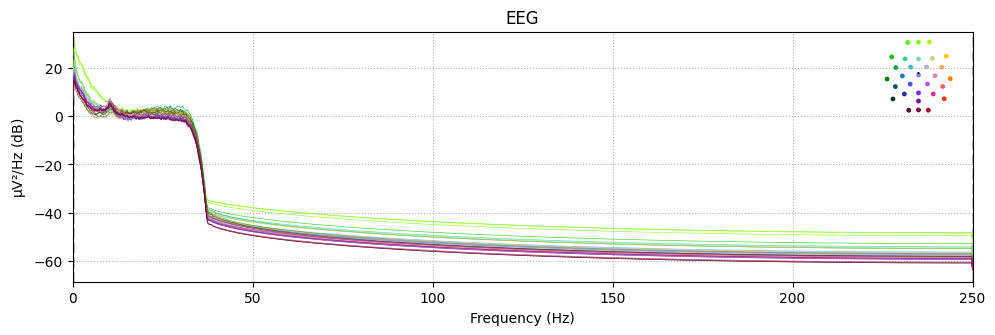

In [129]:
raw.plot_psd()

In [131]:
raw.info['bads'] # = ['O2']

[]

# Preprocessing

In [ ]:
# Check eog
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

In [ ]:
# Check ecg
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

In [154]:
# Apply ICA to n_components that desribe up to 99% of the variance
ica = mne.preprocessing.ICA(0.99).fit(raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Omitting 51327 of 666473 (7.70%) samples, retaining 615146 (92.30%) samples.


<ipython-input-154-5a1f39c488b2>:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = mne.preprocessing.ICA(0.99).fit(raw)


Selecting by explained variance: 12 components
Fitting ICA took 7.0s.


Creating RawArray with float64 data, n_channels=15, n_times=666473
    Range : 0 ... 666472 =      0.000 ...  1332.944 secs
Ready.


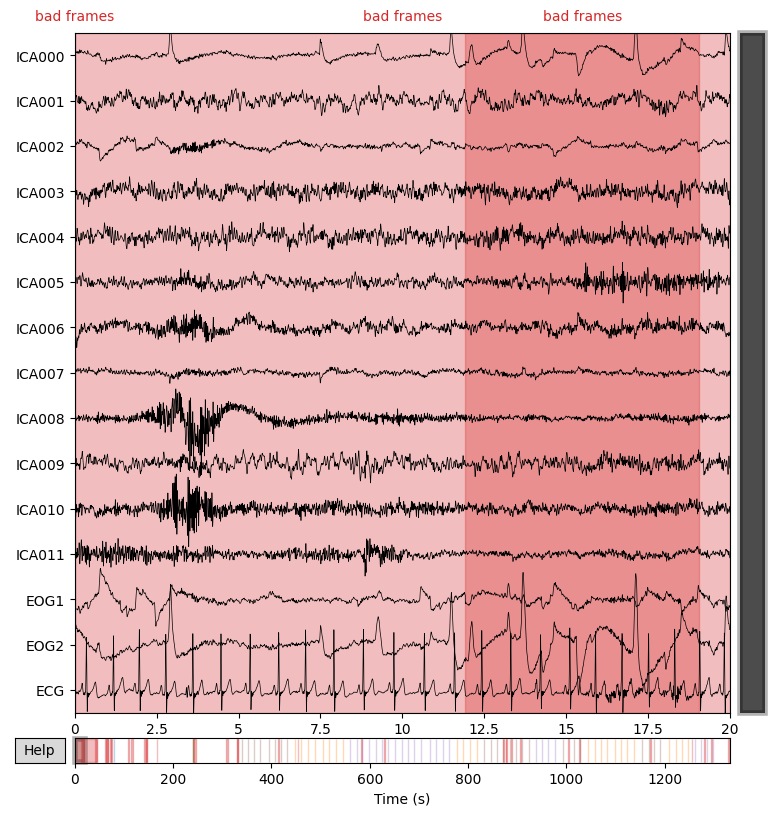

In [133]:
ica.plot_sources(raw, show_scrollbars=True)

In [ ]:
ica.plot_components()

In [157]:
bads_eog, eog_scores = ica.find_bads_eog(raw, measure='correlation', threshold=0.8) #threshold=2.5)
bads_ecg, ecg_scores = ica.find_bads_ecg(raw, measure='correlation', threshold=0.8)

Using EOG channels: EOG1, EOG2
Omitting 51327 of 666473 (7.70%) samples, retaining 615146 (92.30%) samples.
Omitting 51327 of 666473 (7.70%) samples, retaining 615146 (92.30%) samples.
Omitting 51327 of 666473 (7.70%) samples, retaining 615146 (92.30%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design

In [158]:
print('bad eog:', bads_eog)
print('bad ecg:', bads_ecg)

bad eog: [0, 2]
bad ecg: []


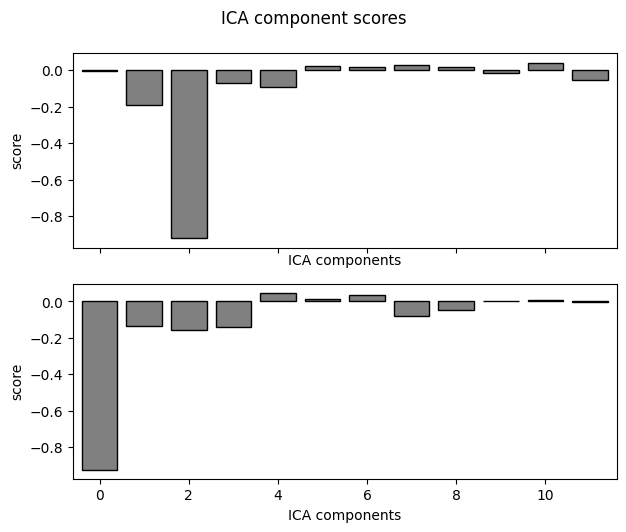

In [150]:
# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

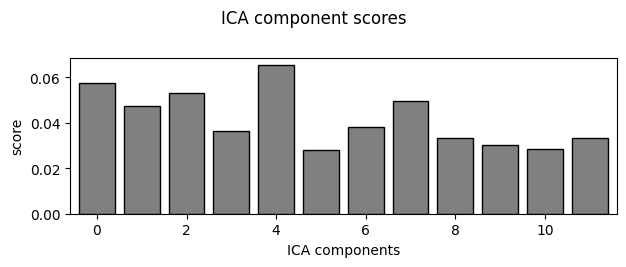

In [151]:
# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

In [159]:
ica.exclude = bads_ecg + bads_eog
raw = ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


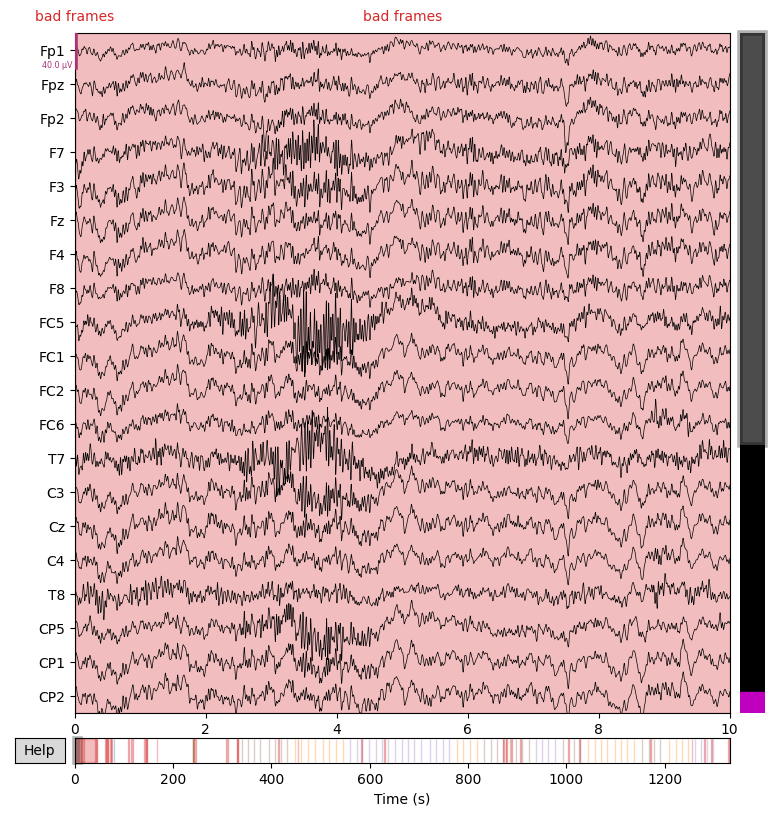

Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none


In [160]:
raw.plot()

Setting 51327 of 666473 (7.70%) samples to NaN, retaining 615146 (92.30%) samples.
Effective window size : 4.096 (s)


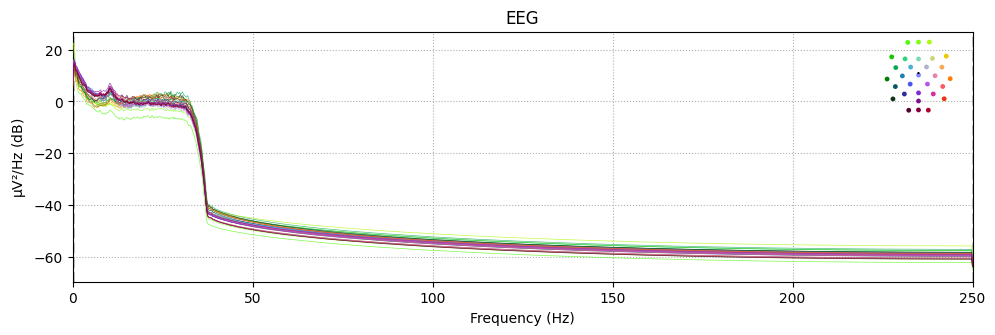

In [161]:
raw.plot_psd()

# Microstates

In [162]:
# get data without bad frames
channels = mne.pick_types(raw.info, meg=False, eeg=True)
data, times = raw.get_data(picks=channels, reject_by_annotation='omit', return_times=True)
data.shape

Omitting 51327 of 666473 (7.70%) samples, retaining 615146 (92.30%) samples.


(30, 615146)

In [163]:
# get only resting state
resting = data[:,:events[1][0]//2]
resting.shape

(30, 60338)

In [164]:
# Segment the data into microstates
n_states=4
states = np.arange(n_states)
maps, segmentation, polarity = microstates.segment(data, n_states=n_states, return_polarity=True) #, thresh=1e-20, verbose=True, min_peak_dist=1, n_inits=4)

Finding 4 microstates, using 10 random intitializations
Converged at 37 iterations.
GEV of found microstates: 0.437522
Converged at 30 iterations.
GEV of found microstates: 0.437189
Converged at 21 iterations.
GEV of found microstates: 0.437582
Converged at 34 iterations.
GEV of found microstates: 0.437189
Converged at 21 iterations.
GEV of found microstates: 0.437522
Converged at 19 iterations.
GEV of found microstates: 0.437627
Converged at 28 iterations.
GEV of found microstates: 0.438112
Converged at 33 iterations.
GEV of found microstates: 0.437189
Converged at 16 iterations.
GEV of found microstates: 0.438111
Converged at 16 iterations.
GEV of found microstates: 0.438143


In [165]:
# Plot the topographic maps of the found microstates
microstates.plot_maps(maps, mne.pick_info(raw.info, channels))

In [ ]:
nn = 500
n0 = 1000

microstates.plot_segmentation(segmentation[n0:n0+nn], raw.get_data()[:,n0:n0+nn],
                              raw.times[n0:n0+nn], polarity=polarity[n0:n0+nn])

# Distributions & transition probabilities

In [166]:
def get_segmentation(data, maps):
    activation = maps.dot(data)
    return np.argmax(np.abs(activation), axis=0)

def count_occur(data, states):
    # count microstates occurrence
    #tmp_states, counts = np.unique(segmentation, return_counts=True)
    # also safe if all microstates are present
    idx = np.searchsorted(states,data)
    idx[idx==len(states)] = 0
    mask = states[idx]==data
    counts = np.bincount(idx[mask])
    
    return counts

def count_joint_occur(data, states):
    # Compute joint matrix
    n_states = len(states)
    q_matrix = np.zeros((n_states,n_states))

    for i in range(n_states):
        # init state
        s_in = data[:-1] == states[i]
    
        for j in range(i, n_states):
            # ending state
            s_out = data[1:] == states[j]
            # count occurrences
            q_matrix[i,j] = np.sum(s_in*s_out)
        
    # simmetrize matrix
    q_matrix += q_matrix.T - np.diag(q_matrix.diagonal())
    
    return q_matrix

def get_prob(data, states):
    counts = count_occur(data, states)
    return counts / np.sum(counts)

def get_q_matrix(data, states):
    q_matrix = count_joint_occur(data, states)
    
    return q_matrix / q_matrix.sum()

def get_t_matrix(data, states):
    t_matrix = count_joint_occur(data, states)
    # normalize each row
    t_matrix = t_matrix / t_matrix.sum(axis=1)[:,None]
    
    return t_matrix

def plot_distributions(prob, t_matrix):
    plt.figure(figsize=(16,4))

    # probability distribution
    plt.subplot(1,2,1)

    plt.bar(states.astype(str), prob)

    plt.xlabel('state', size=size)
    plt.ylabel('prob', size=size)

    # transition matrix
    plt.subplot(1,2,2)

    plt.imshow(t_matrix, extent=[0,n_states,0,n_states], cmap='summer')

    for i in range(n_states):
        for j in range(n_states):
            plt.text(j+0.2, n_states-1-i+0.4, '{:0.3f}'.format(t_matrix[i,j]))

    plt.xticks(states+0.5, labels=states)
    plt.yticks(states+0.5, labels=states[::-1])

    plt.xlabel('state t+1', size=size)
    plt.ylabel('state t', size=size)
    plt.colorbar()

    plt.show()

In [167]:
prob = get_prob(segmentation, states)
q_matrix = get_q_matrix(segmentation, states)
t_matrix = get_t_matrix(segmentation, states)

plot_distributions(prob, t_matrix)

In [168]:
# Get epoched data
epochs = mne.Epochs(raw, events, tmin=0, tmax=6, baseline=None, event_id=events_id)

Not setting metadata
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


In [169]:
epochs

Number of events,73
Events,s1: 1s11: 24s2: 1s21: 24s31: 23
Time range,0.000 – 6.000 sec
Baseline,off


In [170]:
epochs.drop_bad()

Loading data for 73 events and 3001 original time points ...
7 bad epochs dropped


Number of events,66
Events,s1: 1s11: 23s2: 0s21: 22s31: 20
Time range,0.000 – 6.000 sec
Baseline,off


In [171]:
tasks = ['s11', 's21', 's31']
n_tasks = len(tasks)

q_matrix_task = np.zeros((n_tasks, n_states, n_states))
t_matrix_task = np.zeros((n_tasks, n_states, n_states))
prob_task = np.zeros((n_tasks, n_states))

## loop over tasks
for i, task in enumerate(tasks):
    # get epochs
    task_data = epochs[task].get_data(picks='eeg')
    
    ## loop over trials
    for trial in task_data:
        # get segmentation
        segmented = get_segmentation(trial, maps)
        
        ## count occurrences for probability
        prob_task[i] += count_occur(segmented, states)
        
        ## count occurrences for transition matrix
        q_matrix_task[i] += count_joint_occur(segmented, states)
    
    ## normalize
    prob_task[i] = prob_task[i] / np.sum(prob_task[i])
    t_matrix_task[i] = q_matrix_task[i] / q_matrix_task[i].sum(axis=1)[:,None]

Loading data for 23 events and 3001 original time points ...
Loading data for 22 events and 3001 original time points ...
Loading data for 20 events and 3001 original time points ...


In [ ]:
for i, task in enumerate(tasks):
    plot_distributions(prob_task[i], t_matrix_task[i])

In [172]:
## distributions at resting
# get segmentation
resting_states = get_segmentation(resting, maps)
p_rest = get_prob(resting_states, states)
q_rest = get_q_matrix(resting_states, states)
t_rest = get_t_matrix(resting_states, states)

# Transition cost

In [173]:
# start matlab engine
import matlab.engine

eng = matlab.engine.start_matlab()
eng.addpath('SB_toolbox-main', nargout=0)

In [174]:
# convert empirical distributions to Matlab arrays
ini_dist = matlab.double(p_rest.reshape(-1,1).tolist())
Q = matlab.double(q_rest.tolist())

Ps = []

for i, task in enumerate(tasks):

    tar_dist = matlab.double(prob_task[i].reshape(-1,1).tolist())
    
    P =  eng.solveSBP(ini_dist,tar_dist,Q)
    Ps.append(P)

In [175]:
plt.figure(figsize=(8,5))

plt.bar(['positive', 'neutral', 'negative'], Ps)

plt.ylabel('cost', size=size)
plt.xlabel('stimulus', size=size)
plt.title('Transition cost - task from resting', size=size+4)

plt.show()

Channels marked as bad: none
Channels marked as bad: none


In [124]:
np.save('C002.npy', np.array(Ps))